In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from statistics import mode

In [2]:
class Node():
    # Variables in this class will be
    # 1. type: Type of the node (Decision , Label).
    # 2. attribute: If this is a decison node, then attribute contains the name of the attribute that this node will be testing.
    # 3. Possible values: For the given attribute value, this list will have all possible values of the attribute.
    # 4. Child Node Links: This is a collection of the child nodes from this node.
    # 5. Label: If the type of the node is label, then this variable will hold the name of the variable.
    def __init__(self):
        self.node_type = None
        self.attribute = None
        self.values = None
        self.children = {}
        self.label = None

In [3]:
class Tree:
    # Variables in this class will be 
    # 1. root_node: Node
    # 
    # Methods in this class will be
    # 1. train(): Train the tree
    # 2. predict_target(): Test the tree
    # 3. get_gini_coefficient(): Calculate gini coefficient of given dataset
    # 4. get_best_attributes_list(): Calculate gain of given dataset
    
    def __init__(self, attribute_values):
        self.root_node = Node()  
        self.attribute_values = attribute_values
    
    def get_gini_coefficient(self, dataset):
        probability_vector = dataset['target'].value_counts().div(len(dataset))
        gini_coefficient = 1-(probability_vector.apply(lambda x: x**2).sum())
        return gini_coefficient

    def get_best_attributes_list(self, dataset, attributes):
        gini_coefficients_list = []
        # main_gini_coefficient = get_gini_coefficient(dataset)
        for col in attributes:
            values = self.attribute_values[col]
            sum_gini_coefficient = 0
            for val in values:
                sub_dataset_len = len(dataset[dataset[col]==val])
                gini_coefficient = self.get_gini_coefficient(dataset[dataset[col]==val])
                sum_gini_coefficient += (sub_dataset_len/len(dataset))*gini_coefficient
            # info_gain = main_entropy - avg_entropy
            gini_coefficients_list.append([col, sum_gini_coefficient])
        gini_coefficients_list = pd.DataFrame(gini_coefficients_list,columns=['Attribute','Gini_Coefficient'])
        return gini_coefficients_list.sort_values(by=['Gini_Coefficient'],ascending=True)
    
    def train(self, dataset, attributes):
        node = Node()
        target_labels = dataset.value_counts(subset=['target'],sort=True)
        
        # Termination condition
        if target_labels.iloc[0] == len(dataset):
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node

        if attributes.size == 0:
            node.node_type='LEAF'
            node.label = target_labels.idxmax()[0]
            return node

        info_gain_list = self.get_best_attributes_list(dataset, attributes) # Dataset and attribute lists are changing every time, should we take original one every time.
        best_attribute = info_gain_list.iloc[0]['Attribute']
    
        node.node_type='DECISION'
        node.attribute = best_attribute
        node.values = self.attribute_values[best_attribute]
        
        index = np.argwhere(attributes==best_attribute)
        sub_attributes = np.delete(attributes, index) 

        for value in node.values:
            sub_dataset = dataset[dataset[best_attribute]==value]

            if sub_dataset.empty:
                node.attribute = None
                node.values = None

                node.node_type='LEAF'
                node.label = target_labels.idxmax()[0]

            else:            
                sub_decision_tree = self.train(sub_dataset,sub_attributes)
                node.children[value] = sub_decision_tree

        return node
        
        
    def generate_tree(self, dataset, attributes):
        self.root_node = self.train(dataset, attributes)
          
    def predict_target(self, node, instance):
        if node.node_type =='LEAF':
            return node.label
        best_attribute = node.attribute
        best_attribute_value = instance[best_attribute]
        next_node = node.children[best_attribute_value]
        return self.predict_target(next_node,instance)

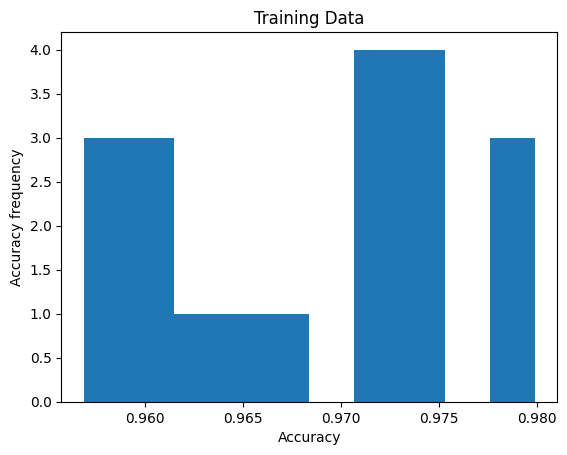

Mean accuracy of model over training set: 0.968390804597701 and Standart deviation: 0.007816937073985904


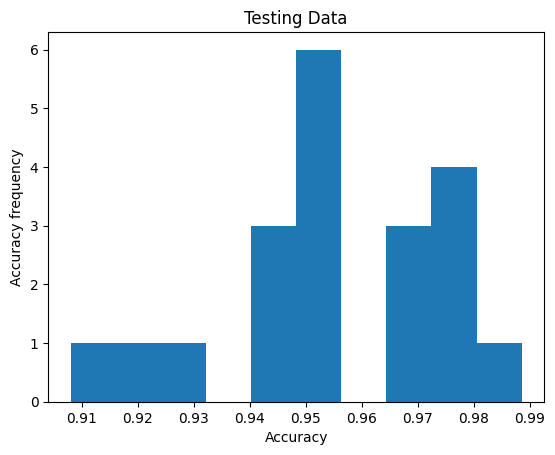

Mean accuracy of model over testing set: 0.9551724137931036 and Standart deviation: 0.019875421225046666


In [4]:
# Code to test the tree class

data = pd.read_csv('house_votes_84.csv')
attributes = np.array(data.columns.drop('target'))
attribute_values = {}
for attribute in attributes:
    attribute_values[attribute] = data[attribute].unique()
    
training_accuracy_list = []
testing_accuracy_list = []

for trial in range(20):
    train_set, test_set = train_test_split(data,test_size=0.2,shuffle=True, random_state=random.randint(1,1000))
    
    decision_tree = Tree(attribute_values)
    
    decision_tree.generate_tree(train_set, attributes)

    correct_predictions = 0
    for index, instance in train_set.iterrows():
        predicted_class = decision_tree.predict_target(decision_tree.root_node, instance)
        if instance['target']==predicted_class:
            correct_predictions+=1
    train_accuracy = (correct_predictions/len(train_set))
    training_accuracy_list.append(train_accuracy)

    correct_predictions = 0
    for index, instance in test_set.iterrows():
        predicted_class = decision_tree.predict_target(decision_tree.root_node, instance)
        if instance['target']==predicted_class:
            correct_predictions+=1
    test_accuracy = (correct_predictions/len(test_set))
    testing_accuracy_list.append(test_accuracy)
    
training_accuracy_list = np.array(training_accuracy_list)
testing_accuracy_list = np.array(testing_accuracy_list)

mean_training_accuracy = np.mean(training_accuracy_list)
std_training_accuracy = np.std(training_accuracy_list)

mean_testing_accuracy = np.mean(testing_accuracy_list)
std_testing_accuracy = np.std(testing_accuracy_list)

plt.hist(training_accuracy_list)
plt.title('Training Data')
plt.ylabel('Accuracy frequency')
plt.xlabel('Accuracy')
plt.show()

print('Mean accuracy of model over training set: {} and Standart deviation: {}'.format(mean_training_accuracy,std_training_accuracy))

plt.hist(testing_accuracy_list)
plt.title('Testing Data')
plt.ylabel('Accuracy frequency')
plt.xlabel('Accuracy')
plt.show()

print('Mean accuracy of model over testing set: {} and Standart deviation: {}'.format(mean_testing_accuracy,std_testing_accuracy))

